In [2]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

### 1. Read SCM & ERA data

In [15]:
# Contains selected ERA-features, as identified in 3_yield_model_with_era.ipynb
era_final = pd.read_csv("data/features/era_features_filtered_case11.csv")
era_raw = pd.read_csv("data/ERA5/era_basic_preprocessed_filtered_feature_structure_1993_2016.csv")
era_raw = era_raw.assign(model="ERA", init_month=12)

# Contains hindcasts as csv with basic preprocessing
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")

# Concatenate SCM and filter by year
scm = pd.concat([nmme, c3s, apcc], ignore_index=True).drop_duplicates()
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(9, 11))].reset_index(drop=True)

# Store variables that are used through this notebook
init_months = scm["init_month"].unique().tolist()
scm_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]
weather_columns_raw = [c for c in era_raw.columns if ("rain" in c) or ("tmean" in c)]
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set([c.split("_")[1] for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))

era_raw = era_raw.loc[:, ["year", "model", "init_month"] + [c for c in weather_columns_raw if c.split("_")[1] in relevant_municipalities]]
weather_columns_raw = [c for c in era_raw.columns if ("rain" in c) or ("tmean" in c)]

# Preview
scm.sample(5)

,model,year,init_month,forecasted_month,rain,tmean,lat,lon
20850,GFDL,2012,9,9,0.004682,13.670374,-36.0,-59.0
336325,ECCC,2012,9,9,0.002507,11.886041,-39.0,-59.0
111931,NASA,2000,9,10,0.005879,19.128175,-30.0,-56.0
263983,METFR,2008,10,10,0.001536,8.032190,-41.0,-69.0
138144,CMCC,2005,9,10,0.002323,17.486871,-35.0,-58.0


In [17]:
weather_columns_final

['tmeanrain_buenos aires coronel suarez_9',
 'tmeansquared_buenos aires coronel suarez_11',
 'tmeanrain_buenos aires coronel suarez_11',
 'rainsquared_buenos aires hipolito yrigoyen_9']

### 2. Filter SCM locations

**2.1 Obtain polygon shapes of relevant municipalities**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. SCM data is often provided in e.g. 1° x 1° grid cells. For each location, we need to find the grid cells that are closest. 

In [4]:
# Read all polygon shapes of Argentinian municipalities
gdf_adm2 = gpd.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# Concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# Filter polygon shapes by the relevant municipalities
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_municipalities), ["name", "geometry"]].reset_index(drop=True)
# Convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# Preview
name_to_shape

{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**2.2 Preview SCM locations and relevant municipality locations**

<Axes: >

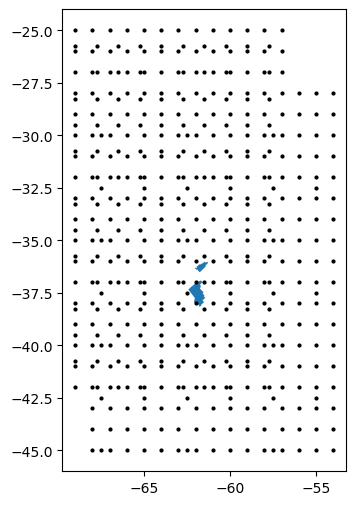

In [5]:
# Convert SCM dataframe to geodataframe to facilitate spatial filtering in the next section
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"]), crs="EPSG:4326")

# Preview SCM locations and municipality polygons
base = gdf_adm2.plot(figsize=(6,6), linewidth=.2)
gpd.GeoDataFrame(scm[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black", markersize=4)

**2.3 Filter SCM hindcasts**

For each relevant municipality, we select a grid cell location from each SCM that is closest to that municipality. If a SCM has a sparse resolution, it may be that the same grid cell is used for both locations.

In [6]:
filtered_scm = []
for model in scm_models:
    # Get current model and the lat-lon coordinates of its forecasts
    current_model = scm.loc[scm["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    selected_grid_cells = []
    for count, municipality in enumerate(relevant_municipalities):
        # Get the nearest lat-lon pair to all locations (municipalities)
        grid_cell_for_current_municipality = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[municipality])[1][0]]).transpose().assign(location=municipality).reset_index(drop=True)
        selected_grid_cells.append(grid_cell_for_current_municipality)
    # Save in dataframe
    selected_grid_cells = pd.concat(selected_grid_cells, ignore_index=True)
    # The lat-lon pairs that are selected are merged with the name of their location; all other lat-lon pairs are dropped
    current_model = current_model.merge(selected_grid_cells, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    # Append the locations for this model
    filtered_scm.append(current_model)        
filtered_scm = pd.concat(filtered_scm, ignore_index=True, axis=0)
scm = scm.merge(filtered_scm, on=["model", "lat", "lon", "geometry"]).dropna()
#scm["location"] = scm["location"].str.replace("buenos aires ", "")

<Axes: >

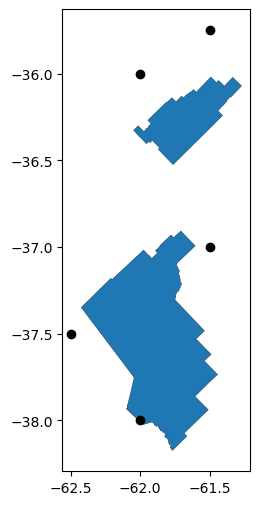

In [7]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gpd.GeoDataFrame(scm[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

In [8]:
scm.shape

(4608, 10)

### 3. Bring SCM hindcasts into feature structure

In [9]:
# Bring NMME hindcasts into right structure where features are columns and rows are model-year-init_month
scm_pivot = scm.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
scm_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in scm_pivot.columns]
scm_pivot.columns = [c.strip("_") for c in scm_pivot.columns]
era_raw.columns = ["year", "model", "init_month"] + weather_columns_raw
weather_columns_raw = [c for c in era_raw.columns if ("rain" in c) or ("tmean" in c)]
scm_pivot = scm_pivot.loc[: , [c for c in scm_pivot.columns if c in era_raw.columns]]
scm_pivot.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_10,tmean_buenos aires coronel suarez_11,tmean_buenos aires hipolito yrigoyen_9,tmean_buenos aires hipolito yrigoyen_10,tmean_buenos aires hipolito yrigoyen_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_10,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9,rain_buenos aires hipolito yrigoyen_10,rain_buenos aires hipolito yrigoyen_11
478,ECMWF,2008,10,NaN,13.496454,17.978906,NaN,16.08114,20.584375,NaN,0.002805,0.002200,NaN,0.003199,0.002670
444,ECMWF,1997,9,8.329218,12.699213,15.937341,11.074152,15.53280,18.598749,0.002181,0.002738,0.003534,0.002437,0.003155,0.004837
218,CWB,1993,11,NaN,NaN,16.401147,NaN,NaN,16.401147,NaN,NaN,0.001053,NaN,NaN,0.001053


### 4. Adjust Bias

In [10]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in scm_models:
        adjusted_init_months = []
        for month in [9, 10, 11]:
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [11]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_10,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9,rain_buenos aires hipolito yrigoyen_10,rain_buenos aires hipolito yrigoyen_11,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_10,tmean_buenos aires coronel suarez_11,tmean_buenos aires hipolito yrigoyen_9,tmean_buenos aires hipolito yrigoyen_10,tmean_buenos aires hipolito yrigoyen_11
758,KMA,2005,11,NaN,NaN,0.002243,NaN,NaN,0.002406,NaN,NaN,18.482256,NaN,NaN,19.913637
1008,PNU,1993,9,0.003561,0.004766,0.004349,0.003851,0.006668,0.004083,9.858313,12.864310,16.121026,11.788628,14.678532,17.664677
424,ECCC,2014,10,NaN,0.005794,0.004620,NaN,0.009219,0.007619,NaN,13.124753,16.117987,NaN,14.982728,17.684526


### Fill with climatology

In [12]:
def r2_by_feature_init_month_and_scm(im, models, observed_df, scm_df, columns):
    model_to_col_to_r2 = dict.fromkeys(models)
    for model in models:
        # Get forecasted features for model and init month, with year as index and all weather columns
        forecasted_scm = scm_df.xs(im, level=2, drop_level=True).xs(model, level=0, drop_level=True)[columns]
        # Calculate LOYO mean of ERA
        loyo_mean = (observed_df[columns].sum() - observed_df[columns]) / (observed_df.shape[0] - 1)
        
        ss_total = mse(observed_df[columns], loyo_mean, multioutput="raw_values")
        ss_model = mse(observed_df[columns], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        
        model_to_col_to_r2[model] = dict(zip(columns, current_r2))
    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

In [14]:
weather_columns_final

['tmeanrain_buenos aires coronel suarez_9',
 'tmeansquared_buenos aires coronel suarez_11',
 'tmeanrain_buenos aires coronel suarez_11',
 'rainsquared_buenos aires hipolito yrigoyen_9']

In [18]:
r2_9 = r2_by_feature_init_month_and_scm(9, scm_models, era_raw, scm_bias_adjusted.set_index(["model", "year", "init_month"]), weather_columns_raw)
r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
rain_buenos aires hipolito yrigoyen_10                   [HMC]
tmean_buenos aires coronel suarez_10               [NCEP, KMA]
tmean_buenos aires coronel suarez_11                    [NASA]
tmean_buenos aires hipolito yrigoyen_10    [CCSM4, ECMWF, KMA]
tmean_buenos aires hipolito yrigoyen_11            [NCEP, DWD]
tmean_buenos aires hipolito yrigoyen_9                  [ECCC]
Name: level_1, dtype: object

In [19]:
r2_10 = r2_by_feature_init_month_and_scm(10, scm_models, era_raw, scm_bias_adjusted.set_index(["model", "year", "init_month"]), [c for c in weather_columns_raw if ("_9" not in c)])
r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
rain_buenos aires coronel suarez_10                [NCEP, CMCC, ECMWF, JMA, UKMO, ECCC, KMA]
rain_buenos aires hipolito yrigoyen_10                                          [ECMWF, JMA]
tmean_buenos aires coronel suarez_10       [CCSM4, NCEP, CMCC, ECMWF, JMA, METFR, ECCC, P...
tmean_buenos aires coronel suarez_11                    [GFDL, NASA, CMCC, ECMWF, JMA, ECCC]
tmean_buenos aires hipolito yrigoyen_10      [CCSM4, CMCC, ECMWF, JMA, METFR, PNU, KMA, CWB]
tmean_buenos aires hipolito yrigoyen_11             [NCEP, CMCC, ECMWF, JMA, ECCC, KMA, CWB]
Name: level_1, dtype: object

In [20]:
r2_11 = r2_by_feature_init_month_and_scm(11, scm_models, era_raw, scm_bias_adjusted.set_index(["model", "year", "init_month"]), [c for c in weather_columns_raw if ("_11" in c)])
r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
rain_buenos aires coronel suarez_11                                [GFDL, ECMWF, UKMO, ECCC]
tmean_buenos aires coronel suarez_11              [NASA, NCEP, ECMWF, METFR, ECCC, KMA, BOM]
tmean_buenos aires hipolito yrigoyen_11    [NASA, NCEP, CMCC, ECMWF, JMA, METFR, UKMO, EC...
Name: level_1, dtype: object

In [21]:
init_month_to_skill = dict.fromkeys([9, 10, 11])
init_month_to_skill[9] = r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[10] = r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[11] = r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()

In [22]:
# LOYO Climatology
era_columns_no_skill_sep = era_raw.loc[:, ["year"] + [c for c in weather_columns_raw if c not in list(init_month_to_skill[9].keys())]].set_index("year")
sep_climatology = (era_columns_no_skill_sep.sum() - era_columns_no_skill_sep) / (era_columns_no_skill_sep.shape[0] - 1)
era_columns_no_skill_oct = era_raw.loc[:, ["year"] + [c for c in weather_columns_raw if c not in list(init_month_to_skill[10].keys())]].set_index("year")
oct_climatology = (era_columns_no_skill_oct.sum() - era_columns_no_skill_oct) / (era_columns_no_skill_oct.shape[0] - 1)
era_columns_no_skill_nov = era_raw.loc[:, ["year"] + [c for c in weather_columns_raw if c not in list(init_month_to_skill[11].keys())]].set_index("year")
nov_climatology = (era_columns_no_skill_nov.sum() - era_columns_no_skill_nov) / (era_columns_no_skill_nov.shape[0] - 1)

scm_basis_expansion_climatology = scm_bias_adjusted.set_index(["model", "init_month", "year"])[weather_columns_raw]
scm_basis_expansion_climatology.xs(9, axis=0, level=1, drop_level=True).reset_index().set_index("year")[[c for c in weather_columns_raw if c not in list(init_month_to_skill[9].keys())]]
#scm_basis_expansion_climatology.loc[scm_basis_expansion_climatology.index.get_level_values("init_month") == 9, [c for c in weather_columns_raw if c not in list(init_month_to_skill[9].keys())]]

,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_10,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9,rain_buenos aires hipolito yrigoyen_11,tmean_buenos aires coronel suarez_9
year,,,,,,
1993,0.004112,0.003387,0.003548,0.004287,0.003932,9.197847
1994,0.002970,0.004071,0.003549,0.003535,0.003933,10.041453
1995,0.000888,0.000800,0.003390,0.001159,0.003372,11.151007
1996,0.001425,0.002046,0.002250,0.001581,0.002799,11.973557
1997,0.004561,0.005794,0.005888,0.004965,0.007619,9.550317
...,...,...,...,...,...,...
2012,0.004116,0.002526,0.004618,0.004965,0.005414,11.690889
2013,0.001546,0.004073,0.004195,0.002612,0.003727,11.958879
2014,0.002916,0.005033,0.005509,0.003509,0.003400,11.132468


In [28]:
scm_basis_expansion_climatology = scm_bias_adjusted.set_index(["model", "init_month", "year"])[weather_columns_raw]
scm_basis_expansion_climatology.xs(9, axis=0, level=1, drop_level=True).reset_index().set_index("year")[[c for c in weather_columns_raw if c not in list(init_month_to_skill[9].keys())]] = sep_climatology
scm_basis_expansion_climatology.xs(10, axis=0, level=1, drop_level=True).reset_index().set_index("year")[[c for c in weather_columns_raw if c not in list(init_month_to_skill[10].keys())]] = oct_climatology
scm_basis_expansion_climatology.xs(11, axis=0, level=1, drop_level=True).reset_index().set_index("year")[[c for c in weather_columns_raw if c not in list(init_month_to_skill[11].keys())]] = nov_climatology

for im in [9, 10, 11]:
    for col in list(init_month_to_skill[im].keys()):
        scm_with_no_skill = [c for c in scm_models if c not in init_month_to_skill[im][col]]
        for model in scm_with_no_skill:
            #print("{}, {}, {}".format(im, col, model))
            filter_model = scm_basis_expansion_climatology.index.get_level_values("model") == model
            filter_init_month = scm_basis_expansion_climatology.index.get_level_values("init_month") == im
            scm_basis_expansion_climatology.xs(im, axis=0, level=1, drop_level=True).xs(model, level=0, drop_level=True).reset_index().set_index("year")[col] = (era_raw[col].sum() - era_raw[col]) / (era_raw[col].shape[0] - 1)

scm_basis_expansion_climatology = scm_basis_expansion_climatology.reset_index()
scm_basis_expansion_climatology.sort_values(by=["model", "year", "init_month"])

,model,init_month,year,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_10,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9,rain_buenos aires hipolito yrigoyen_10,rain_buenos aires hipolito yrigoyen_11,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_10,tmean_buenos aires coronel suarez_11,tmean_buenos aires hipolito yrigoyen_9,tmean_buenos aires hipolito yrigoyen_10,tmean_buenos aires hipolito yrigoyen_11
0,BOM,9,1993,0.004112,0.003387,0.003548,0.004287,0.003897,0.003932,9.197847,13.068098,16.035928,10.916707,14.735126,17.579579
1,BOM,10,1993,NaN,0.003091,0.003139,NaN,0.002625,0.003344,NaN,12.878782,17.209101,NaN,14.693005,18.756522
2,BOM,11,1993,NaN,NaN,0.003537,NaN,NaN,0.003908,NaN,NaN,15.777773,NaN,NaN,17.314235
3,BOM,9,1994,0.002970,0.004071,0.003549,0.003535,0.006222,0.003933,10.041453,12.899759,16.097533,11.742206,14.802466,17.649358
4,BOM,10,1994,NaN,0.003901,0.005527,NaN,0.005173,0.007149,NaN,13.838652,16.892847,NaN,15.323049,18.714060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,UKMO,10,2015,NaN,0.003787,0.003899,NaN,0.005089,0.003732,NaN,12.690435,15.847365,NaN,14.587247,17.288041
1148,UKMO,11,2015,NaN,NaN,0.004606,NaN,NaN,0.003784,NaN,NaN,17.602486,NaN,NaN,18.835965
1149,UKMO,9,2016,0.001035,0.000863,0.002487,0.001349,0.000886,0.002768,10.892755,15.342537,18.625115,12.470137,17.144327,20.438807
1150,UKMO,10,2016,NaN,0.005794,0.004628,NaN,0.007325,0.003951,NaN,15.348600,17.657976,NaN,17.152635,19.640091


### Trouble-Shooting

In [231]:
cmcc_sep_rain_san_justo = scm_bias_adjusted.loc[(scm_bias_adjusted["model"] == "CMCC") & (scm_bias_adjusted["init_month"] == 9), ["model", "init_month", "year", "rain_santa fe san justo_11"]].reset_index(drop=True)
era_raw_rain_san_justo = era_raw.loc[:, ["model", "init_month", "year", "rain_santa fe san justo_11"]]

cmcc_sep_rain_san_justo["rain_santa fe san justo_11"] = cmcc_sep_rain_san_justo["rain_santa fe san justo_11"]**2
era_raw_rain_san_justo["rain_santa fe san justo_11"] = era_raw_rain_san_justo["rain_santa fe san justo_11"]**2
#era_final_rainsquared_san_just = era_final.loc[:, ["rainsquared_santa fe san justo_11"]]
cmcc_sep_rain_san_justo_std = standardize_loyo(cmcc_sep_rain_san_justo)["rain_santa fe san justo_11"]
era_raw_rain_san_justo_std = standardize_loyo(era_raw_rain_san_justo)["rain_santa fe san justo_11"]

#cmcc_sep_rain_san_justo = (cmcc_sep_rain_san_justo["rain_santa fe san justo_11"] - cmcc_sep_rain_san_justo["rain_santa fe san justo_11"].mean()) / cmcc_sep_rain_san_justo["rain_santa fe san justo_11"].std()
#era_raw_rain_san_justo = (era_raw_rain_san_justo["rain_santa fe san justo_11"] - era_raw_rain_san_justo["rain_santa fe san justo_11"].mean()) / era_raw_rain_san_justo["rain_santa fe san justo_11"].std()

r2_score(era_raw_rain_san_justo_std, cmcc_sep_rain_san_justo_std)


0.04443443698736349

In [ ]:
def r2_by_feature_init_month_and_scm(im, models, observed_df, scm_df, columns):
    model_to_col_to_r2 = dict.fromkeys(models)
    for model in models:
        current_r2 = r2_score(observed_df[columns], scm_df.xs(im, level=2, drop_level=True).xs(model, level=0, drop_level=True)[columns], multioutput="raw_values").tolist()
        model_to_col_to_r2[model] = dict(zip(columns, current_r2))
    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

In [193]:
r2_9 = r2_by_feature_init_month_and_scm(9, scm_models, era_raw.set_index("year")[weather_columns_raw], scm_bias_adjusted.set_index(["model", "year", "init_month"]), weather_columns_raw)
r2_9
#r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list)

,GFDL,CCSM4,NASA,NCEP,CMCC,DWD,ECMWF,JMA,METFR,UKMO,ECCC,PNU,KMA,CWB,HMC,BOM
rain_buenos aires coronel suarez_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_buenos aires coronel suarez_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_buenos aires coronel suarez_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_buenos aires hipolito yrigoyen_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_buenos aires hipolito yrigoyen_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_buenos aires hipolito yrigoyen_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_entre rios nogoya_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_entre rios nogoya_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain_entre rios nogoya_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.148938,NaN,0.010032,NaN,NaN,NaN,NaN,NaN
rain_santa fe las colonias_9,NaN,NaN,NaN,NaN,NaN,NaN,0.144817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
r2_10 = r2_by_feature_init_month_and_scm(10, scm_models, era_raw.set_index("year")[weather_columns_raw], scm_bias_adjusted.set_index(["model", "year", "init_month"]), [c for c in weather_columns_raw if ("_9" not in c)])
r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
rain_buenos aires coronel suarez_10              [NCEP, ECMWF, JMA, UKMO, ECCC]
rain_buenos aires hipolito yrigoyen_10                             [ECMWF, JMA]
rain_entre rios nogoya_11                                   [CMCC, METFR, ECCC]
rain_santa fe san justo_11                                                [DWD]
tmean_buenos aires coronel suarez_10            [CCSM4, NCEP, CMCC, ECMWF, JMA]
tmean_buenos aires coronel suarez_11                   [GFDL, NASA, ECMWF, JMA]
tmean_buenos aires hipolito yrigoyen_10     [CMCC, ECMWF, JMA, METFR, PNU, KMA]
tmean_buenos aires hipolito yrigoyen_11          [NCEP, CMCC, ECMWF, JMA, ECCC]
tmean_entre rios nogoya_10                                              [ECMWF]
tmean_entre rios nogoya_11                                  [NASA, ECMWF, ECCC]
tmean_santa fe las colonias_11                         [GFDL, ECMWF, ECCC, BOM]
tmean_santa fe san justo_10                                  [CMCC, METFR, KMA]
tmean_santa fe san justo_11     

In [188]:
r2_11 = r2_by_feature_init_month_and_scm(11, scm_models, era_raw.set_index("year")[weather_columns_raw], scm_bias_adjusted.set_index(["model", "year", "init_month"]), [c for c in weather_columns_raw if ("_11" in c)])
r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list)

level_0
rain_buenos aires coronel suarez_11                                                  [ECMWF]
rain_entre rios nogoya_11                                         [CCSM4, CMCC, ECMWF, UKMO]
rain_santa fe las colonias_11                                                  [ECMWF, UKMO]
rain_santa fe san justo_11                                              [CCSM4, ECMWF, UKMO]
tmean_buenos aires coronel suarez_11                   [NASA, NCEP, ECMWF, METFR, ECCC, KMA]
tmean_buenos aires hipolito yrigoyen_11    [NASA, NCEP, CMCC, ECMWF, JMA, METFR, ECCC, KM...
tmean_entre rios nogoya_11                              [GFDL, NCEP, ECMWF, UKMO, ECCC, KMA]
tmean_santa fe las colonias_11              [NCEP, CMCC, ECMWF, JMA, METFR, UKMO, ECCC, CWB]
tmean_santa fe san justo_11                [NCEP, CMCC, DWD, ECMWF, JMA, METFR, UKMO, ECC...
Name: level_1, dtype: object

### Analyse a bit the skill

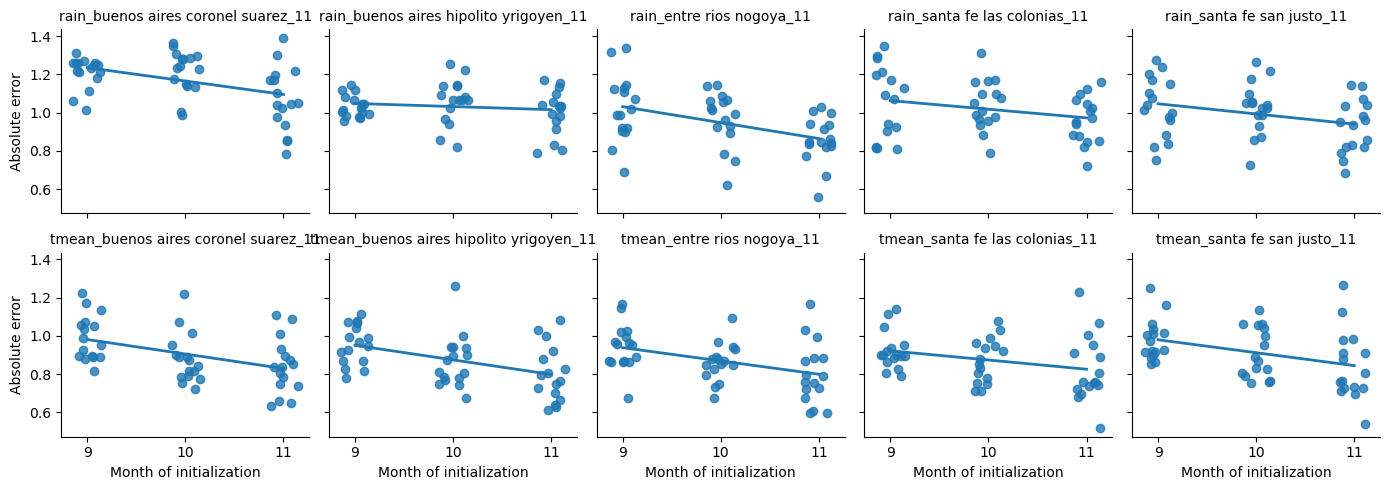

In [12]:
era_features = pd.read_csv("data/ERA5/era_basic_preprocessed_filtered_feature_structure_1993_2016.csv")[[c for c in scm_bias_adjusted.columns if ("_11" in c) or ("year" == c)]].set_index("year")
scm_test  = scm_bias_adjusted.copy().set_index(["model", "year", "init_month"])[[c for c in scm_bias_adjusted.columns if ("_11" in c)]]

# standardize
scm_test = (scm_test - scm_test.mean()) / scm_test.std()
era_features = (era_features - era_features.mean()) / era_features.std()

scm_bias_test = abs(scm_test.subtract(era_features, level=1)).groupby(level=["model", "init_month"]).mean().reset_index()

fig, axs = plt.subplots(2, 5, figsize=(14, 5), sharey=True, sharex=True)
axs = axs.ravel()
cols = [c for c in scm_bias_test.columns if ("_11" in c)]

for ax, col in zip(axs, cols):
    sns.regplot(data=scm_bias_test, x="init_month", y=col, x_jitter=.15, ci=None, ax=ax, line_kws={"linewidth":2})
    #ax.get_legend().remove()
    ax.set_title(col, size=10)
    ax.set_xticks(list(range(9,12,1)))
    ax.spines[['right', 'top']].set_visible(False)
    if "tmean" in col:
        ax.set_xlabel("Month of initialization", fontsize=10)
    else:
        ax.set_xlabel("")
    if "coronel" in col:
        ax.set_ylabel("Absolute error", size=10)
    else:
        ax.set_ylabel("")
    #ax.set_xticks([9, 10, 11])

plt.tight_layout()
plt.show()

### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [29]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for model in data["model"].unique():
        standardized_data_init_month = []
        for month in data["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = data.loc[(data["year"] != year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    df_standardized = data.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])
    # Store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True)).reset_index()

    # standardize expanded features again
    df_standardized = standardize_loyo(X)
    
    return df_standardized

In [30]:
scm_basis_expansion = apply_basis_expansion(scm_basis_expansion_climatology)
basis_expansion_weather_columns = [c for c in scm_basis_expansion.columns if ("tmean" in c) or ("rain" in c)]
scm_basis_expansion.sample(3)

,year,model,init_month,tmeansquared_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_10,tmeansquared_buenos aires coronel suarez_11,tmeansquared_buenos aires hipolito yrigoyen_9,tmeansquared_buenos aires hipolito yrigoyen_10,tmeansquared_buenos aires hipolito yrigoyen_11,rainsquared_buenos aires coronel suarez_9,...,rainsquared_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9,rainsquared_buenos aires hipolito yrigoyen_10,rainsquared_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_9,tmeanrain_buenos aires coronel suarez_10,tmeanrain_buenos aires coronel suarez_11,tmeanrain_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires hipolito yrigoyen_10,tmeanrain_buenos aires hipolito yrigoyen_11
23,2016,NASA,11,NaN,NaN,0.945367,NaN,NaN,-0.286210,NaN,...,-0.821107,NaN,NaN,-0.264177,NaN,NaN,-0.790838,NaN,NaN,-0.145585
20,2013,CWB,11,NaN,NaN,0.979773,NaN,NaN,0.827864,NaN,...,-0.897022,NaN,NaN,-0.817312,NaN,NaN,-0.887168,NaN,NaN,-1.063686
23,2016,CMCC,9,0.434813,2.221239,0.885535,-0.056989,2.032992,0.556007,-0.402013,...,0.891384,-0.235657,0.048299,1.129544,-0.198724,-0.138647,1.379949,-0.052244,0.561251,1.589388


### Analyse again the skill

In [294]:
weather_columns_final = ['rainsquared_buenos aires hipolito yrigoyen_9', 'tmeanrain_santa fe san justo_10', 'tmeanrain_entre rios nogoya_10', 'rainsquared_santa fe san justo_11', 
                         'rainsquared_santa fe las colonias_11', 'tmeanrain_santa fe san justo_11', 'tmeanrain_buenos aires hipolito yrigoyen_11', 'tmeanrain_buenos aires coronel suarez_11', 'tmeansquared_buenos aires coronel suarez_11']

weather_columns_10_11 = [c for c in weather_columns_final if ("_10" in c) or ("_11" in c)]
weather_columns_11 = [c for c in weather_columns_final if ("_11" in c)]
era_features = pd.read_csv("data/features/era_features_filtered_case8.csv")
era_features = era_features[["year"] + [c for c in era_features.columns if ("tmean" in c) or ("rain" in c)]].set_index("year")
era_features.columns = weather_columns_final
scm_test  = scm_basis_expansion.copy().set_index(["model", "year", "init_month"])[era_features.columns]

In [352]:
def r2_by_feature_init_month_and_scm(im, models, observed_df, scm_df, columns):
    model_to_col_to_r2 = dict.fromkeys(models)
    for model in models:
        # Get forecasted features for model and init month, with year as index and all weather columns
        forecasted_scm = scm_df.xs(im, level=2, drop_level=True).xs(model, level=0, drop_level=True)[columns]
        # Calculate LOYO mean of ERA
        loyo_mean = (observed_df[columns].sum() - observed_df[columns]) / (observed_df.shape[0] - 1)
        
        ss_total = mse(observed_df[columns], loyo_mean, multioutput="raw_values")
        ss_model = mse(observed_df[columns], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        
        model_to_col_to_r2[model] = dict(zip(columns, current_r2))
    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

In [356]:
r2_9 = r2_by_feature_init_month_and_scm(9, scm_models, era_features, scm_test, weather_columns_final)
r2_9

,GFDL,CCSM4,NASA,NCEP,CMCC,DWD,ECMWF,JMA,METFR,UKMO,ECCC,PNU,KMA,CWB,HMC,BOM
tmeanrain_santa fe san justo_10,NaN,NaN,NaN,NaN,NaN,0.113859,NaN,NaN,0.200668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rainsquared_santa fe san justo_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rainsquared_santa fe las colonias_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_santa fe san justo_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_buenos aires hipolito yrigoyen_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_buenos aires coronel suarez_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rainsquared_buenos aires hipolito yrigoyen_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_entre rios nogoya_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeansquared_buenos aires coronel suarez_11,0.001,NaN,NaN,NaN,NaN,0.099245,0.050131,NaN,0.121173,NaN,0.098939,0.00957,NaN,0.012921,NaN,NaN


In [357]:
r2_10 = r2_by_feature_init_month_and_scm(10, scm_models, era_features, scm_test, weather_columns_10_11)
#r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list)
r2_10

,GFDL,CCSM4,NASA,NCEP,CMCC,DWD,ECMWF,JMA,METFR,UKMO,ECCC,PNU,KMA,CWB,HMC,BOM
tmeanrain_santa fe san justo_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361483,NaN,NaN,NaN
tmeanrain_entre rios nogoya_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096980,NaN,NaN,NaN
rainsquared_santa fe san justo_11,NaN,NaN,NaN,NaN,0.130945,NaN,NaN,NaN,NaN,NaN,0.162261,NaN,NaN,NaN,NaN,NaN
rainsquared_santa fe las colonias_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_santa fe san justo_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_buenos aires hipolito yrigoyen_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029796,NaN,0.220456,NaN
tmeanrain_buenos aires coronel suarez_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072300,NaN,NaN,NaN
tmeansquared_buenos aires coronel suarez_11,0.155015,NaN,NaN,NaN,NaN,NaN,0.332115,NaN,NaN,NaN,0.166726,NaN,0.107052,0.189184,NaN,0.05586


In [358]:
r2_11 = r2_by_feature_init_month_and_scm(11, scm_models, era_features, scm_test, weather_columns_11)
#r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list)
r2_11

,GFDL,CCSM4,NASA,NCEP,CMCC,DWD,ECMWF,JMA,METFR,UKMO,ECCC,PNU,KMA,CWB,HMC,BOM
rainsquared_santa fe san justo_11,0.259786,NaN,NaN,0.146428,NaN,NaN,NaN,NaN,NaN,0.176582,NaN,NaN,NaN,NaN,NaN,NaN
rainsquared_santa fe las colonias_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_santa fe san justo_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_buenos aires hipolito yrigoyen_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007892,NaN
tmeanrain_buenos aires coronel suarez_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmeansquared_buenos aires coronel suarez_11,0.186220,0.173634,0.178458,0.306951,NaN,NaN,0.159608,NaN,0.249847,NaN,0.180266,0.018909,0.148706,0.111048,NaN,0.065709


In [359]:
init_month_to_skill = dict.fromkeys([9, 10, 11])
init_month_to_skill[9] = r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[10] = r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[11] = r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()

### 5. Fill SCM forecasts with climatology if not skillful

In [418]:
scm_basis_expansion_climatology = scm_basis_expansion.set_index(["model", "init_month", "year"])[weather_columns_final]
scm_basis_expansion_climatology.loc[scm_basis_expansion_climatology.index.get_level_values("init_month") == 9, weather_columns_final] = 0
scm_basis_expansion_climatology.loc[scm_basis_expansion_climatology.index.get_level_values("init_month") == 10, [c for c in weather_columns_final if c not in list(init_month_to_skill[10].keys())]] = 0
scm_basis_expansion_climatology.loc[scm_basis_expansion_climatology.index.get_level_values("init_month") == 11, [c for c in weather_columns_final if c not in list(init_month_to_skill[11].keys())]] = 0

In [361]:
for im in [10, 11]:
    for col in list(init_month_to_skill[im].keys()):
        scm_with_no_skill = [c for c in scm_models if c not in init_month_to_skill[im][col]]
        for model in scm_with_no_skill:
            #print("{}, {}, {}".format(im, col, model))
            filter_model = scm_basis_expansion_climatology.index.get_level_values("model") == model
            filter_init_month = scm_basis_expansion_climatology.index.get_level_values("init_month") == im
            scm_basis_expansion_climatology.loc[(filter_model) & (filter_init_month), col] = 0

scm_basis_expansion_climatology = scm_basis_expansion_climatology.reset_index()

### 5. Fill past months with ERA data

In [31]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.loc[scm_era["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield [kg/ha],yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9
337,2009,DWD,10,2970.297029,0.080890,-0.313077,3.801359,0.927969,1.680521
522,2011,ERA,12,3647.926666,0.195453,-0.789133,0.380902,2.817331,0.201614
158,1997,CMCC,11,2623.252920,0.175913,0.760139,-0.600187,-0.097363,-0.440915
1007,2008,NCEP,11,2024.453891,-0.290659,0.425418,1.793393,-0.785105,-0.641597
289,1993,DWD,10,2037.439151,-0.046171,0.507882,-0.078414,1.108682,-0.504002


### 7. Analyse Bias

In [363]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

In [364]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in scm_models:
    for month in init_months:
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        current_scm_bias = abs(current_scm[weather_columns] - era_bias)
        current_scm_info = current_scm[['model', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']]
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_bias.append(current_scm)
all_bias = pd.concat(all_bias)

In [365]:
all_bias = all_bias.set_index(["model", "init_month"]).stack().reset_index()
all_bias.columns = ["model", "init_month", "feature", "bias"]

<Axes: ylabel='model'>

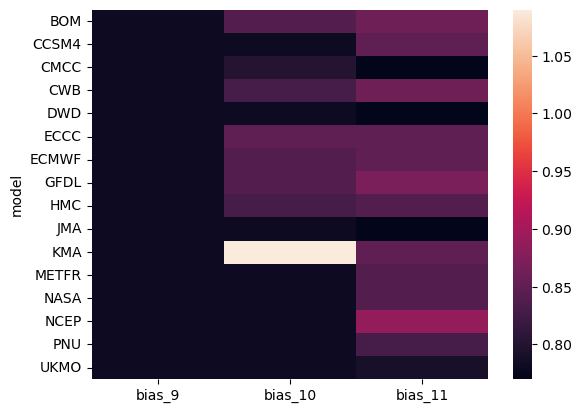

In [366]:
bias_heatmap = (all_bias.loc[(all_bias["init_month"] == 9)].groupby("model")["bias"].mean().reset_index()
                .merge(all_bias.loc[(all_bias["init_month"] == 10)].groupby("model")["bias"].mean().reset_index()
                        .merge(all_bias.loc[(all_bias["init_month"] == 11)].groupby("model")["bias"].mean().reset_index(), on="model", suffixes=("", "_11")), on="model", suffixes=("_9", "_10"))
                .round(2))
sns.heatmap(bias_heatmap.set_index("model"))

<Axes: xlabel='bias', ylabel='feature'>

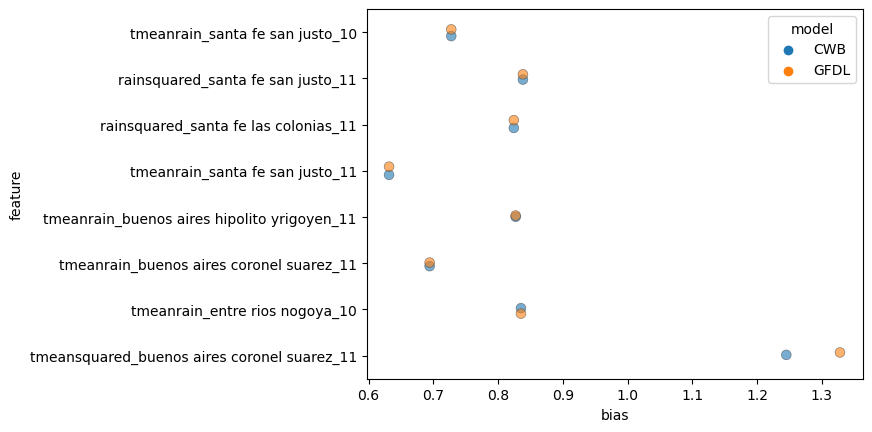

In [367]:
sns.stripplot(data=all_bias.loc[(all_bias["init_month"] == 10) & (all_bias["model"].isin(["CWB", "GFDL"]))], x="bias", y="feature", orient="h", s=7, linewidth=0.5, alpha=.6, hue="model", jitter=True, size=(20,20))

## EXPORT

In [32]:
scm_era.to_csv("data/features/scm_era_features_filtered_case25.csv", index=False)